# Data 620 Final Project

Jimmy Ng, Corey Arnouts

In this final project, we decide to look at the recent stock market performance from the S&P 500. The first part of the analysis is to review the price movement by 11 sectors (from the S&P 500) from month to date, i.e. 2020-12-01 to 2020-12-11. There's a very strong up trend in the 'Energy' sector, whereas there's a considerable down trend in the 'Utilities' sector. We decide to do text mining and sentiment analysis by scraping Twitter for each stock from the S&P 500, date ranges from 2020-12-03 to 2020-12-14. We have gathered 100 to 200 tweets for each stock and then complied them into a csv that has over 50+ thousands unique, original tweets (no retweet) during this period. The second part of the analysis is about network analysis.

##### Part one presentation

https://www.youtube.com/watch?v=OxilOMy4q-0

# Part One: Text Mining plus Sentiment Analysis

## SET UP

### import module

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('vader_lexicon')
#nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import re
from collections import Counter
from wordcloud import WordCloud
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
%matplotlib inline

In [2]:
# use 3 decimal places in output display
pd.set_option("display.precision", 3)

# do not wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)

# set max rows displayed in output
pd.set_option("display.max_rows", 20)

# set max colwidth to show full text
pd.set_option('display.max_colwidth', -1)

### read data

In [3]:
sp500_df = pd.read_csv('stock_data_month_to_date_20201211.csv', encoding = "cp1252")
tDf = pd.read_csv('tweets_Df.csv', encoding = "cp1252", parse_dates = ['created'])

In [4]:
sp500_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 7 columns):
symbol                  502 non-null object
company_name            502 non-null object
sector                  502 non-null object
begin_20201201_price    502 non-null float64
end_20201211_price      502 non-null float64
percent_change          502 non-null float64
rank                    502 non-null int64
dtypes: float64(3), int64(1), object(3)
memory usage: 27.5+ KB


In [5]:
tDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71718 entries, 0 to 71717
Data columns (total 9 columns):
sector           71718 non-null object
symbol           71718 non-null object
company_name     71718 non-null object
id               71718 non-null int64
text             71718 non-null object
favoriteCount    71718 non-null int64
retweetCount     71718 non-null int64
created          71718 non-null datetime64[ns]
screenName       71718 non-null object
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 4.9+ MB


In [6]:
sp500_df

,symbol,company_name,sector,begin_20201201_price,end_20201211_price,percent_change,rank
0,OXY,Occidental Petroleum,Energy,15.13,20.89,0.381,1
1,APA,Apache Corporation,Energy,12.37,16.10,0.302,2
2,FANG,Diamondback Energy,Energy,39.85,50.11,0.257,3
3,MRO,Marathon Oil Corp.,Energy,5.86,7.06,0.205,4
4,AAL,American Airlines Group,Industrials,14.27,17.05,0.195,5
5,HES,Hess Corporation,Energy,47.76,56.63,0.186,6
6,NLSN,Nielsen Holdings,Industrials,16.13,19.10,0.184,7
7,BKR,Baker Hughes Co,Energy,19.23,22.67,0.179,8
8,DIS,The Walt Disney Company,Communication Services,149.44,175.72,0.176,9
9,HAL,Halliburton Co.,Energy,17.08,19.83,0.161,10


In [7]:
tDf

,sector,symbol,company_name,id,text,favoriteCount,retweetCount,created,screenName
0,Communication Services,ATVI,Activision Blizzard,1334537346939686912,"Enter $baba jan15 300c 3.35ppc (1con)\r\n\r\ncurrently overextended in $ATVI with 6cons, will look to trim some on profit… https://t.co/IGrU41D6bI",0,0,2020-12-03 16:37:52,OptionsBruh
1,Communication Services,ATVI,Activision Blizzard,1334547061199527936,50 DMA Support today: $AFGD $AINC $AIRG $ATVI ... https://t.co/aW7zteKP9U,0,0,2020-12-03 17:16:28,SwingTradeBot
2,Communication Services,ATVI,Activision Blizzard,1334555851172925441,$ATVI in Uptrend: RSI indicator exits oversold zone. View odds for this and other indicators:… https://t.co/UKbBZLcrYQ,0,1,2020-12-03 17:51:24,Tickeron
3,Communication Services,ATVI,Activision Blizzard,1334555947365261320,$ATVI [D] - This is a tough breakout!\r\nMade with @TrendSpider \r\nhttps://t.co/mhw72Ffx9f,0,0,2020-12-03 17:51:47,KaladinTD
4,Communication Services,ATVI,Activision Blizzard,1334559945396776965,$ATVI a DUD as of now! still holding an 1/15 85c though hopefully a mid december/christmas pop!,0,0,2020-12-03 18:07:40,brick_mayer
5,Communication Services,ATVI,Activision Blizzard,1334564634636980224,@snyder98 Yes. $ATVI C&amp;H + eSIX analysis is part of CPAT Magazine this week. Here is $ATVI (daily &amp; weekly CH) https://t.co/YqEjLBLMqi,0,0,2020-12-03 18:26:18,surinotes
6,Communication Services,ATVI,Activision Blizzard,1334565245411528705,Check out this setup on the 180d4hr chart on $ATVI. Could be setting up for a long play if it can break out of this… https://t.co/uhxOP6PtNN,9,0,2020-12-03 18:28:44,StasSerfes
7,Communication Services,ATVI,Activision Blizzard,1334565419915636736,@snyder98 $ATVI C&amp;H in Daily chart https://t.co/GX454xZJRl,0,0,2020-12-03 18:29:25,surinotes
8,Communication Services,ATVI,Activision Blizzard,1334570769981059073,I think $ATVI might be my favorite long term chart right now.,3,0,2020-12-03 18:50:41,ch33zypizza
9,Communication Services,ATVI,Activision Blizzard,1334573141998366720,Negative sentiment for Activision Blizzard with moderate activity on social media. $ATVI https://t.co/4ezBFxKFXx,0,0,2020-12-03 19:00:06,SentimEntropy


### price change (%) by sector MTD (month-to-date)

In [8]:
sp500_df.groupby('sector')['percent_change'].mean().sort_values(ascending = False)*100

sector
Energy                    13.568
Communication Services    1.755 
Industrials               1.218 
Information Technology    1.040 
Financials                0.965 
Health Care               0.466 
Real Estate               0.145 
Consumer Staples          0.069 
Consumer Discretionary   -0.183 
Materials                -0.260 
Utilities                -1.671 
Name: percent_change, dtype: float64

### 'Energy' sector

In [9]:
%%html
<img src = 'Energy_2020-12-11.png', width = 1200, height = 900>

### 'Utilities' sector

In [10]:
%%html
<img src = 'Utilities_2020-12-11.png', width = 1200, height = 900>

## TWEETS

### number of tweets by sector

Information Technology    11762
Industrials               9481 
Consumer Discretionary    9356 
Financials                8863 
Health Care               6956 
Communication Services    6423 
Consumer Staples          5241 
Utilities                 3774 
Energy                    3383 
Real Estate               3356 
Materials                 3123 
Name: sector, dtype: int64


<AxesSubplot:xlabel='sector', ylabel='count'>

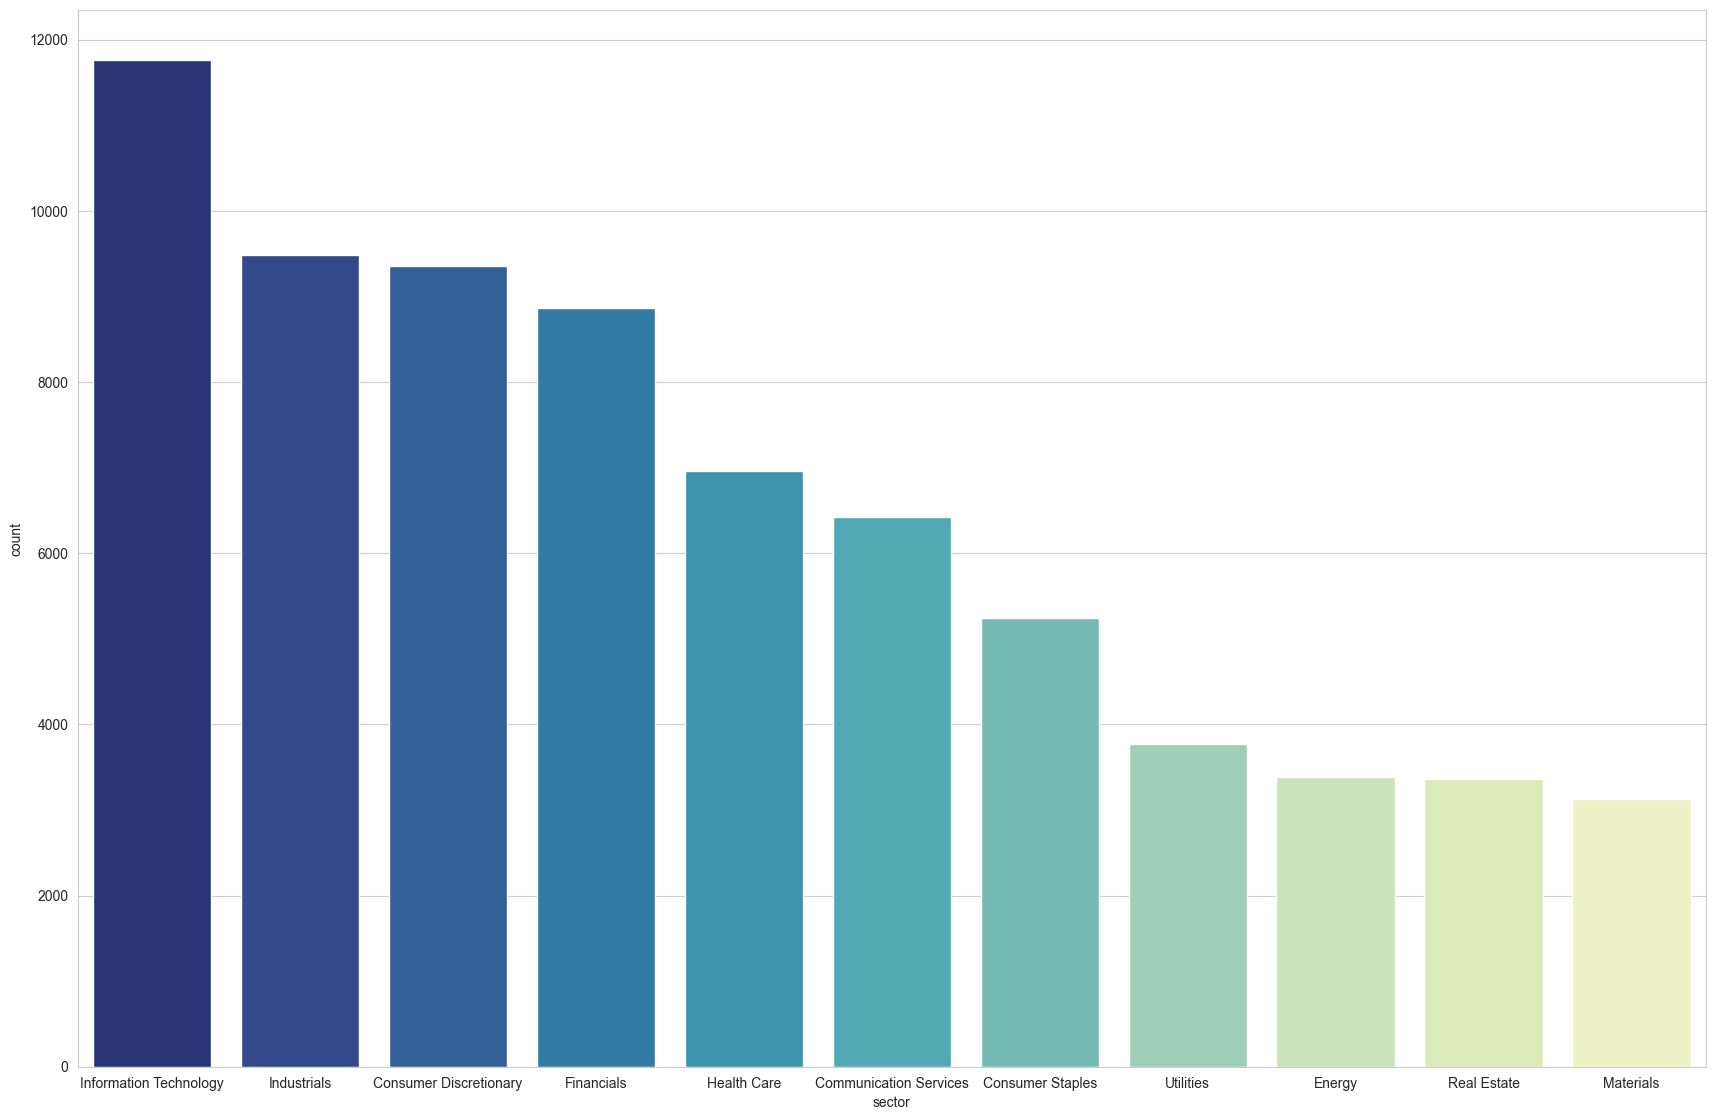

In [11]:
print(tDf['sector'].value_counts())

fig = plt.figure(figsize = (21, 14), dpi = 100)
sns.set_style('whitegrid')
sns.countplot(x = 'sector', data = tDf, palette = 'YlGnBu_r', order = tDf['sector'].value_counts().index)

### basic info

In [12]:
print("The data was collected from between", min(tDf.created), " and ", max(tDf.created))
print("The dataset has", len(tDf.screenName.unique()), "unique users.")
print("The dataset has", len(tDf.id.unique()), "unique tweets.")
print("The tweet with the most favorites had", tDf['favoriteCount'].max(), "favorites.")
print("The tweet with the most retweets had", tDf['retweetCount'].max(), "retweets.")

The data was collected from between 2020-12-03 16:10:58  and  2020-12-14 15:21:53
The dataset has 21327 unique users.
The dataset has 52918 unique tweets.
The tweet with the most favorites had 1267 favorites.
The tweet with the most retweets had 870 retweets.


### tidy text

In [13]:
def tidy_text(text):
        
    # remove hashtags
    step1 = text.str.replace("#[A-Za-z0-9]+", "")
    # remove urls
    step2 = step1.str.replace("https?://[A-Za-z0-9./]+", "")
    # remove screen names
    step3 = step2.str.replace("@[A-Za-z0-9]+", "")
    # lowercase the words
    step4 = step3.str.lower()
    # remove everything else but alphabets
    step5 = step4.str.replace("[^a-z]", " ")
    # tokenize the tweets
    step6 = step5.apply(lambda x: x.split())
    # remove stop words
    stop_words = stopwords.words('english')
    step7 = step6.apply(lambda x: [i for i in x if i not in stop_words])  
    # lemmatisation of words 
    lemma = nltk.WordNetLemmatizer()
    step8 = step7.apply(lambda x: [lemma.lemmatize(i) for i in x])  
    
    return step8

In [14]:
%%time
tDf["tidy_token"] = tidy_text(tDf.text)
tDf["tidy_text"] = tDf.tidy_token.apply(lambda x: " ".join(x))

Wall time: 7.28 s


In [15]:
tDf.head()

,sector,symbol,company_name,id,text,favoriteCount,retweetCount,created,screenName,tidy_token,tidy_text
0,Communication Services,ATVI,Activision Blizzard,1334537346939686912,"Enter $baba jan15 300c 3.35ppc (1con)\r\n\r\ncurrently overextended in $ATVI with 6cons, will look to trim some on profit… https://t.co/IGrU41D6bI",0,0,2020-12-03 16:37:52,OptionsBruh,"[enter, baba, jan, c, ppc, con, currently, overextended, atvi, con, look, trim, profit]",enter baba jan c ppc con currently overextended atvi con look trim profit
1,Communication Services,ATVI,Activision Blizzard,1334547061199527936,50 DMA Support today: $AFGD $AINC $AIRG $ATVI ... https://t.co/aW7zteKP9U,0,0,2020-12-03 17:16:28,SwingTradeBot,"[dma, support, today, afgd, ainc, airg, atvi]",dma support today afgd ainc airg atvi
2,Communication Services,ATVI,Activision Blizzard,1334555851172925441,$ATVI in Uptrend: RSI indicator exits oversold zone. View odds for this and other indicators:… https://t.co/UKbBZLcrYQ,0,1,2020-12-03 17:51:24,Tickeron,"[atvi, uptrend, rsi, indicator, exit, oversold, zone, view, odds, indicator]",atvi uptrend rsi indicator exit oversold zone view odds indicator
3,Communication Services,ATVI,Activision Blizzard,1334555947365261320,$ATVI [D] - This is a tough breakout!\r\nMade with @TrendSpider \r\nhttps://t.co/mhw72Ffx9f,0,0,2020-12-03 17:51:47,KaladinTD,"[atvi, tough, breakout, made]",atvi tough breakout made
4,Communication Services,ATVI,Activision Blizzard,1334559945396776965,$ATVI a DUD as of now! still holding an 1/15 85c though hopefully a mid december/christmas pop!,0,0,2020-12-03 18:07:40,brick_mayer,"[atvi, dud, still, holding, c, though, hopefully, mid, december, christmas, pop]",atvi dud still holding c though hopefully mid december christmas pop


### 'Energy' high freq word

In [16]:
energy = Counter()
for i in tDf[(tDf.sector == 'Energy')].tidy_token: energy.update(i)

hf_energy_words = pd.DataFrame(energy.most_common(), columns = ["word", "count"])
hf_energy_words["nchar"] = [len(word) for word in hf_energy_words.word]

# filter by words that at least has more than 3 characters
hf_energy_words[hf_energy_words.nchar >3][["word", "count"]].head(20).reset_index(drop = True)

,word,count
0,stock,1007
1,flow,463
2,today,292
3,sector,246
4,short,220
5,energy,204
6,like,196
7,market,187
8,sell,163
9,covid,143


### 'Utilities' high freq word

In [17]:
utilities = Counter()
for i in tDf[(tDf.sector == 'Utilities')].tidy_token: utilities.update(i)

hf_utilities_words = pd.DataFrame(utilities.most_common(), columns = ["word", "count"])
hf_utilities_words["nchar"] = [len(word) for word in hf_utilities_words.word]

# filter by words that at least has more than 3 characters
hf_utilities_words[hf_utilities_words.nchar >3][["word", "count"]].head(20).reset_index(drop = True)

,word,count
0,stock,1514
1,market,237
2,short,197
3,today,173
4,week,172
5,like,163
6,energy,156
7,company,125
8,price,117
9,flow,100


### 'Energy' word cloud 

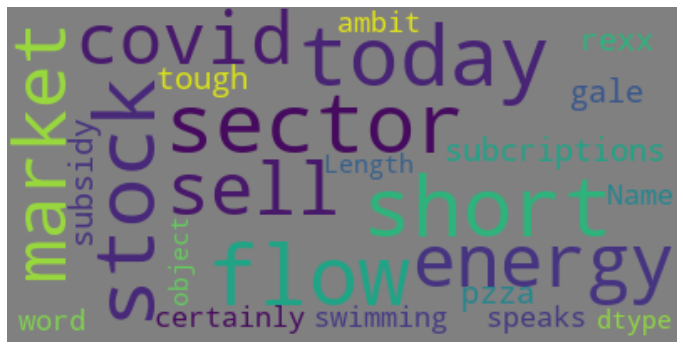

In [18]:
wordcloud = WordCloud(random_state = 1234, max_words = 100, max_font_size = 50, background_color = "grey")\
.generate(str(hf_energy_words.word[hf_energy_words.nchar >3]))
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

### 'Utilities' word cloud 

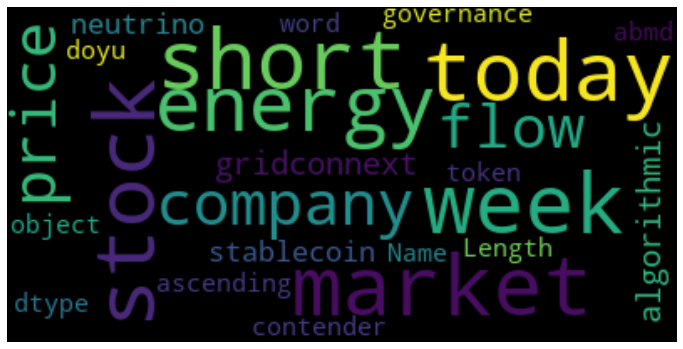

In [19]:
wordcloud2 = WordCloud(random_state = 1234, max_words = 100, max_font_size = 50, background_color = "black")\
.generate(str(hf_utilities_words.word[hf_utilities_words.nchar >3]))
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud2, interpolation = "bilinear")
plt.axis('off')
plt.show()

## SENTIMENT ANALYSIS

### sentiment score

In [20]:
sia = SentimentIntensityAnalyzer()

In [21]:
%%time

tDf['score'] = [sia.polarity_scores(tweet)["compound"] for tweet in tDf['tidy_text']]

Wall time: 10.2 s


### sentiment category

In [22]:
# classify sentiment into 5 distinct categories
tDf.loc[tDf['score'] > .6, 'sentiment'] = "1. extremely positive"
tDf.loc[(tDf['score'] > .2) & (tDf['score'] <= .6), 'sentiment'] = "2. positive"
tDf.loc[(tDf['score'] > -.2) & (tDf['score'] <= .2), 'sentiment'] = "3. neutral"
tDf.loc[(tDf['score'] > -.6) & (tDf['score'] <= -.2), 'sentiment'] = "4. negative"
tDf.loc[tDf['score'] <= -.6, 'sentiment'] = "5. extremely negative"

In [23]:
tDf

,sector,symbol,company_name,id,text,favoriteCount,retweetCount,created,screenName,tidy_token,tidy_text,score,sentiment
0,Communication Services,ATVI,Activision Blizzard,1334537346939686912,"Enter $baba jan15 300c 3.35ppc (1con)\r\n\r\ncurrently overextended in $ATVI with 6cons, will look to trim some on profit… https://t.co/IGrU41D6bI",0,0,2020-12-03 16:37:52,OptionsBruh,"[enter, baba, jan, c, ppc, con, currently, overextended, atvi, con, look, trim, profit]",enter baba jan c ppc con currently overextended atvi con look trim profit,0.440,2. positive
1,Communication Services,ATVI,Activision Blizzard,1334547061199527936,50 DMA Support today: $AFGD $AINC $AIRG $ATVI ... https://t.co/aW7zteKP9U,0,0,2020-12-03 17:16:28,SwingTradeBot,"[dma, support, today, afgd, ainc, airg, atvi]",dma support today afgd ainc airg atvi,0.402,2. positive
2,Communication Services,ATVI,Activision Blizzard,1334555851172925441,$ATVI in Uptrend: RSI indicator exits oversold zone. View odds for this and other indicators:… https://t.co/UKbBZLcrYQ,0,1,2020-12-03 17:51:24,Tickeron,"[atvi, uptrend, rsi, indicator, exit, oversold, zone, view, odds, indicator]",atvi uptrend rsi indicator exit oversold zone view odds indicator,0.000,3. neutral
3,Communication Services,ATVI,Activision Blizzard,1334555947365261320,$ATVI [D] - This is a tough breakout!\r\nMade with @TrendSpider \r\nhttps://t.co/mhw72Ffx9f,0,0,2020-12-03 17:51:47,KaladinTD,"[atvi, tough, breakout, made]",atvi tough breakout made,-0.128,3. neutral
4,Communication Services,ATVI,Activision Blizzard,1334559945396776965,$ATVI a DUD as of now! still holding an 1/15 85c though hopefully a mid december/christmas pop!,0,0,2020-12-03 18:07:40,brick_mayer,"[atvi, dud, still, holding, c, though, hopefully, mid, december, christmas, pop]",atvi dud still holding c though hopefully mid december christmas pop,0.178,3. neutral
5,Communication Services,ATVI,Activision Blizzard,1334564634636980224,@snyder98 Yes. $ATVI C&amp;H + eSIX analysis is part of CPAT Magazine this week. Here is $ATVI (daily &amp; weekly CH) https://t.co/YqEjLBLMqi,0,0,2020-12-03 18:26:18,surinotes,"[yes, atvi, c, amp, h, esix, analysis, part, cpat, magazine, week, atvi, daily, amp, weekly, ch]",yes atvi c amp h esix analysis part cpat magazine week atvi daily amp weekly ch,0.402,2. positive
6,Communication Services,ATVI,Activision Blizzard,1334565245411528705,Check out this setup on the 180d4hr chart on $ATVI. Could be setting up for a long play if it can break out of this… https://t.co/uhxOP6PtNN,9,0,2020-12-03 18:28:44,StasSerfes,"[check, setup, hr, chart, atvi, could, setting, long, play, break]",check setup hr chart atvi could setting long play break,0.340,2. positive
7,Communication Services,ATVI,Activision Blizzard,1334565419915636736,@snyder98 $ATVI C&amp;H in Daily chart https://t.co/GX454xZJRl,0,0,2020-12-03 18:29:25,surinotes,"[atvi, c, amp, h, daily, chart]",atvi c amp h daily chart,0.000,3. neutral
8,Communication Services,ATVI,Activision Blizzard,1334570769981059073,I think $ATVI might be my favorite long term chart right now.,3,0,2020-12-03 18:50:41,ch33zypizza,"[think, atvi, might, favorite, long, term, chart, right]",think atvi might favorite long term chart right,0.459,2. positive
9,Communication Services,ATVI,Activision Blizzard,1334573141998366720,Negative sentiment for Activision Blizzard with moderate activity on social media. $ATVI https://t.co/4ezBFxKFXx,0,0,2020-12-03 19:00:06,SentimEntropy,"[negative, sentiment, activision, blizzard, moderate, activity, social, medium, atvi]",negative sentiment activision blizzard moderate activity social medium atvi,-0.572,4. negative


### distribution of sentiment

In [24]:
tDf.groupby( ["sector"] ).sentiment.value_counts(normalize = True)\
.to_frame(name = "percentage")\
.reset_index()\
.pivot(index = "sector", columns = "sentiment", values = "percentage")


sentiment,1. extremely positive,2. positive,3. neutral,4. negative,5. extremely negative
sector,,,,,
Communication Services,0.099,0.313,0.464,0.102,0.022
Consumer Discretionary,0.109,0.338,0.450,0.084,0.019
Consumer Staples,0.113,0.346,0.440,0.084,0.017
Energy,0.103,0.348,0.452,0.081,0.016
Financials,0.117,0.314,0.449,0.102,0.018
Health Care,0.104,0.330,0.465,0.080,0.021
Industrials,0.101,0.307,0.484,0.086,0.022
Information Technology,0.087,0.341,0.479,0.076,0.017
Materials,0.119,0.322,0.419,0.124,0.016


### 'Energy' words associated with extremely positive/negative sentiment

In [25]:
energy_pos = Counter()
for i in tDf[(tDf.sector == 'Energy') & (tDf.sentiment == '1. extremely positive')].tidy_token: energy_pos.update(i)
energy_neg = Counter()
for i in tDf[(tDf.sector == 'Energy') & (tDf.sentiment == '5. extremely negative')].tidy_token: energy_neg.update(i)
    
hf_energy_pos = pd.DataFrame(energy_pos.most_common(), columns = ["word", "count"])
hf_energy_pos["nchar"] = [len(word) for word in hf_energy_pos.word]

hf_energy_neg = pd.DataFrame(energy_neg.most_common(), columns = ["word", "count"])
hf_energy_neg["nchar"] = [len(word) for word in hf_energy_neg.word]

#### unique, extremely positive word

In [26]:
hf_energy_pos[(hf_energy_pos.nchar >3) & (np.logical_not(hf_energy_pos.word.isin(hf_energy_neg.word)))]\
[["word", "count"]].head(20)\
.reset_index(drop = True)

,word,count
0,energy,69
1,best,54
2,last,33
3,great,32
4,sector,30
5,alert,22
6,follow,21
7,good,20
8,along,20
9,long,19


#### unique, extremely negative word

In [27]:
hf_energy_neg[(hf_energy_neg.nchar >3) & (np.logical_not(hf_energy_neg.word.isin(hf_energy_pos.word)))]\
[["word", "count"]].head(20)\
.reset_index(drop = True)

,word,count
0,terrorist,5
1,attack,5
2,karachi,5
3,stop,4
4,indian,4
5,explosive,4
6,hell,3
7,waiting,3
8,lost,3
9,suicide,3


### 'Utilities' words associated with extremely positive/negative sentiment

In [28]:
utilities_pos = Counter()
for i in tDf[(tDf.sector == 'Utilities') & (tDf.sentiment == '1. extremely positive')].tidy_token: utilities_pos.update(i)
utilities_neg = Counter()
for i in tDf[(tDf.sector == 'Utilities') & (tDf.sentiment == '5. extremely negative')].tidy_token: utilities_neg.update(i)
    
hf_utilities_pos = pd.DataFrame(utilities_pos.most_common(), columns = ["word", "count"])
hf_utilities_pos["nchar"] = [len(word) for word in hf_utilities_pos.word]

hf_utilities_neg = pd.DataFrame(utilities_neg.most_common(), columns = ["word", "count"])
hf_utilities_neg["nchar"] = [len(word) for word in hf_utilities_neg.word]

#### unique, extremely positive word

In [29]:
hf_utilities_pos[(hf_utilities_pos.nchar >3) & (np.logical_not(hf_utilities_pos.word.isin(hf_utilities_neg.word)))]\
[["word", "count"]].head(20)\
.reset_index(drop = True)

,word,count
0,best,43
1,energy,39
2,good,38
3,great,34
4,free,20
5,ready,19
6,love,18
7,long,15
8,term,13
9,share,13


#### unique, extremely negative word

In [30]:
hf_utilities_neg[(hf_utilities_neg.nchar >3) & (np.logical_not(hf_utilities_neg.word.isin(hf_utilities_pos.word)))]\
[["word", "count"]].head(20)\
.reset_index(drop = True)

,word,count
0,weapon,21
1,intense,21
2,defence,20
3,ammunition,20
4,lower,12
5,shit,8
6,uptrend,7
7,bollinger,7
8,band,7
9,view,7
